## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

## Load data

In [2]:
filename = './data/0812B_2th_all.uxd'

In [3]:
def is_header(x):
    n_header = 65
    return x>=n_header

In [4]:
def get_struct_unpacker(fieldspecs, istart, iwidth):
    # https://gist.github.com/rochacbruno/059e1223f5b69d3b99b509a4962cf3aa
    """
    Build the format string for struct.unpack to use, based on the fieldspecs.
    fieldspecs is a list of [name, start, width] arrays.
    Returns a string like "6s4s8s7x7s4x9s".
    """
    unpack_len = 0
    unpack_fmt = ""
    for fieldspec in fieldspecs:
        start = fieldspec[istart] - 1
        end = start + fieldspec[iwidth]
        if start > unpack_len:
            unpack_fmt += str(start - unpack_len) + "x"
        unpack_fmt += str(end - start) + "s"
        unpack_len = end
    struct_unpacker = struct.Struct(unpack_fmt).unpack_from
    return struct_unpacker

In [5]:
from operator import itemgetter
import struct

fieldspecs = [
    # Name, Start, Width, Type
    ["2theta", 1, 10, float],
    ["Intensity", 14, 7, float],
]

iname, istart, iwidth, itype = 0, 1, 2, 3  # field indexes

fieldspecs.sort(key=itemgetter(istart))
struct_unpacker = get_struct_unpacker(fieldspecs, istart, iwidth)
field_indices = range(len(fieldspecs))

In [6]:
def loaddata(filename):
    with open(filename,'r') as fp:
        lines = fp.readlines()

    index_all = range(len(lines))
    index = list(filter(is_header, index_all))
    
    lines_data = list(itemgetter(*index)(lines))
    
    data_dict = {}
    for j, ld in enumerate(lines_data):
        raw_fields = struct_unpacker(ld.encode())
        ld_unpacked = {}
        for i in field_indices:
            fieldspec = fieldspecs[i]
            fieldname = fieldspec[iname]
            cast = fieldspec[itype]
            value = cast(raw_fields[i].decode().strip())
            ld_unpacked[fieldname] = [value]
        if j==0:
            data_dict = ld_unpacked
            continue
        data_dict = {key: [*data_dict[key], *ld_unpacked[key]] for key in data_dict}
    
    return data_dict

In [7]:
data = loaddata(filename)

X = np.array(data['2theta']).astype(np.float64)
Y = np.array(data['Intensity']).astype(np.float64)

## Extract peak

In [8]:
Xb = [36, 40]
index_peak = (X>Xb[0])&(X<Xb[1])

In [9]:
X_peak = X[index_peak]
Y_peak = Y[index_peak]

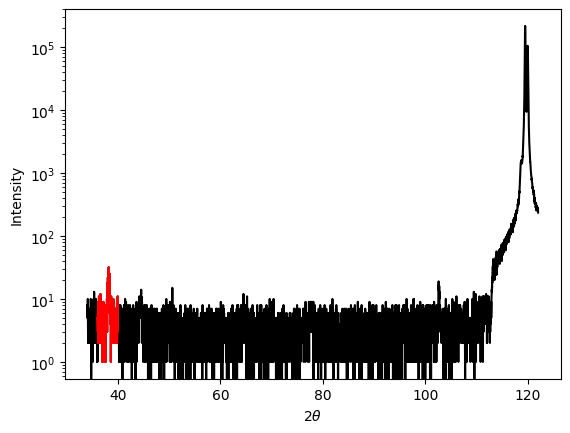

In [10]:
fig,ax = plt.subplots(1,1, figsize=[6.4, 4.8])
ax.plot(X,Y,'k')
ax.plot(X_peak,Y_peak,'r')
ax.set_xlabel(r'$2\theta$')
ax.set_ylabel('Intensity')
ax.set_yscale('log')
plt.show()

## Fit

In [11]:
def func(x, a, b, c, d):
    return a/np.pi*(c/((x-b)**2+c**2))+d

In [12]:
popt, pcov = curve_fit(func, X_peak, Y_peak, bounds=([0.0, Xb[0], 0.01, 0.0], 
                                                     [100, Xb[1], 4.00, 5.0]))
perr = np.sqrt(np.diag(pcov))

In [13]:
X_fitted = np.linspace(Xb[0],Xb[1],200)
Y_fitted = func(X_fitted, *popt)

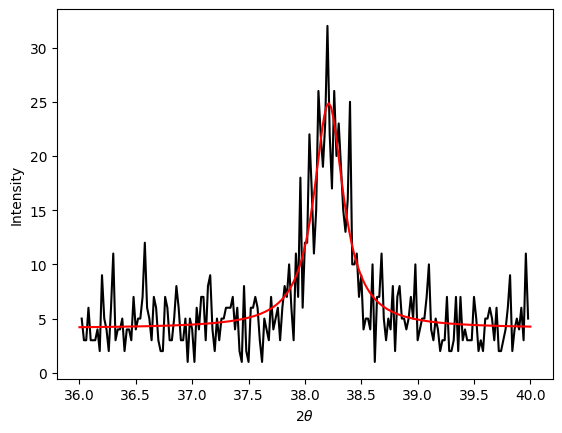

In [14]:
fig2,ax2 = plt.subplots(1,1, figsize=[6.4, 4.8])
plt.plot(X_peak, Y_peak, 'k-')
plt.plot(X_fitted, Y_fitted, 'r-')
ax2.set_xlabel(r'$2\theta$')
ax2.set_ylabel('Intensity')
#ax2.set_yscale('log')
plt.show()

In [15]:
print('Peak position = {:0.4f} +- {:0.4f}'.format(popt[1], perr[1]))
print('FWHM          = {:0.4f} +- {:0.4f}'.format(2*popt[2], 2*perr[2]))
print('Peak value    = {:0.4f} +- {:0.4f}'.format(popt[0]/np.pi/popt[2], np.sqrt((perr[0]/np.pi/popt[2])**2 + 
                                                                           (perr[1]*popt[0]/np.pi/popt[2]**2)**2)))
print('Background    = {:0.4f} +- {:0.4f}'.format(popt[3], perr[3]))

Peak position = 38.2106 +- 0.0084
FWHM          = 0.3179 +- 0.0272
Peak value    = 20.7761 +- 1.8046
Background    = 4.0947 +- 0.2531
